In [1]:
# Base imports
import os
import logging
import numpy as np
import matplotlib.pyplot as plt

# Deep learning imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Image processing
import cv2

# Import segmentation models
from segmentation_models_pytorch import Unet

In [2]:
# Initialize logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
import torchvision.transforms as T

transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor()
])


In [4]:
def calculate_jaccard_score(y_true, y_pred):
    """Calculate Jaccard score (IoU) manually"""
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / (union + 1e-8)

In [5]:
class UnpairedDeepfakeDataset(Dataset):
    def __init__(self, dataset_path, split='train', transform=None, mask_threshold=30, size=(256, 256)):
        self.dataset_path = dataset_path
        self.split = split
        self.transform = transform
        self.mask_threshold = mask_threshold
        self.size = size
        self.real_dir = os.path.join(dataset_path, split, 'real')
        self.fake_dir = os.path.join(dataset_path, split, 'fake')

        # Load fake images
        self.fake_images = [f for f in os.listdir(self.fake_dir)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Load real images
        self.real_images = [f for f in os.listdir(self.real_dir)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        logger.info(f"\nInitializing dataset for split: {split}")
        logger.info(f"Number of fake images: {len(self.fake_images)}")
        logger.info(f"Number of real images: {len(self.real_images)}")

        if len(self.fake_images) == 0:
            raise ValueError("No fake images found!")
        if len(self.real_images) == 0:
            raise ValueError("No real images found!")

    def find_corresponding_real_image(self, fake_img_name):
        """Find the corresponding real image based on filename pattern"""
        # Extract base number and image number from the fake image filename
        parts = fake_img_name.split('_')
        base_number = parts[0]  # base number (e.g., '12345')
        image_number = parts[-1].split('.')[0]  # image number (e.g., '001')

        # First try to match both base number and image number
        matching_real = [img for img in self.real_images
                        if img.startswith(f"{base_number}_{image_number}")]

        if matching_real:
            return matching_real[0]

        # If no exact match is found, try to match only base number
        matching_real_base = [img for img in self.real_images
                            if img.startswith(base_number)]

        if matching_real_base:
            return matching_real_base[0]

        # If no match is found, discard this image by returning None (or raise an error)
        return None


    def generate_manipulation_mask(self, real_img, fake_img):
        """Generate a refined mask based on absolute RGB difference."""
        real_img = real_img.astype(np.float32)
        fake_img = fake_img.astype(np.float32)

        diff = np.abs(real_img - fake_img)
        diff_gray = cv2.cvtColor(diff.astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Apply Otsu's thresholding instead of fixed threshold
        _, mask = cv2.threshold(diff_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Use morphological operations for cleaner masks
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        return mask.astype(np.float32) / 255.0  # Normalize



            # 2. Classifier Guidance (Conceptual - needs a trained classifier model)
            # Placeholder for classifier-guided refinement.
            # In a real implementation, you would use a trained classifier
            # to predict probabilities of regions being manipulated and use
            # these probabilities to refine the initial mask.

            # For now, we will skip classifier guidance for simplicity and return the initial mask.
            # To implement classifier guidance, you would typically:
            #    a. Train a classifier to distinguish between real and fake image patches.
            #    b. Use the classifier to predict manipulation probabilities for patches
            #       within the initial mask regions (and potentially outside).
            #    c. Refine the mask based on these probabilities (e.g., thresholding probabilities,
            #       using probabilities as weights in morphological operations, etc.).


            # 3. Morphological Operations (as before)

    def __len__(self):
        return len(self.fake_images)

    def __getitem__(self, idx):
        try:
            # Load fake image
            fake_img_name = self.fake_images[idx]
            fake_path = os.path.join(self.fake_dir, fake_img_name)

            # Find and load corresponding real image
            real_img_name = self.find_corresponding_real_image(fake_img_name)

            if real_img_name is None:
                # Skip this iteration if no valid real image is found
                return None  # or you can handle it in another way, e.g., logging, raising an exception, etc.

            real_path = os.path.join(self.real_dir, real_img_name)

            # Load both images
            fake_img = cv2.imread(fake_path)
            real_img = cv2.imread(real_path)

            if fake_img is None or real_img is None:
                raise ValueError(f"Failed to load images: {fake_path} or {real_path}")

            # Convert BGR to RGB
            fake_img = cv2.cvtColor(fake_img, cv2.COLOR_BGR2RGB)
            real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)

            # Resize images
            fake_img = cv2.resize(fake_img, self.size)
            real_img = cv2.resize(real_img, self.size)

            # Generate manipulation mask
            mask = self.generate_manipulation_mask(real_img, fake_img)

            # Normalize image and convert to tensor
            fake_img = fake_img.astype(np.float32) / 255.0
            fake_img = torch.FloatTensor(fake_img.transpose(2, 0, 1))

            # Convert mask to tensor
            mask = torch.FloatTensor(mask).unsqueeze(0)

            # Apply transforms only to the image
            if self.transform:
                fake_img = self.transform(fake_img)

            # Return processed fake image and mask
            return fake_img, mask

        except Exception as e:
            logger.error(f"Error loading image pair {fake_img_name}: {str(e)}")
            raise

In [6]:
class UNetModel(nn.Module):
     def __init__(self, input_channels=3, output_channels=1):
         super(UNetModel, self).__init__()
         self.model = Unet(
             encoder_name="resnet34",
             encoder_weights="imagenet",
             in_channels=input_channels,
             classes=output_channels,
         )

     def forward(self, x):
         return self.model(x)

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)  # Ensure output is in [0,1]
        intersection = (pred * target).sum()
        dice_score = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice_score

def combined_loss(pred, target):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = DiceLoss()(pred, target)
    return bce + dice  # Balancing between both losses

In [8]:
class UNetTrainer:
     def __init__(self, model, device, learning_rate=1e-4):
         self.model = model.to(device)
         self.device = device
         self.criterion = DiceLoss()
         self.optimizer = torch.optim.AdamW(
             model.parameters(),
             lr=learning_rate,
             weight_decay=1e-5
         )
         self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
             self.optimizer,
             mode='min',
             factor=0.5,
             patience=3,
             verbose=True
         )

     def train_epoch(self, dataloader):
         self.model.train()
         epoch_loss = 0
         batch_losses = []

         for batch_idx, (images, masks) in enumerate(dataloader):
             images = images.to(self.device)
             masks = masks.to(self.device)

             self.optimizer.zero_grad()
             outputs = self.model(images)

             loss = self.criterion(outputs, masks)
             loss.backward()

             # Gradient clipping
             torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

             self.optimizer.step()

             current_loss = loss.item()
             epoch_loss += current_loss
             batch_losses.append(current_loss)

             if batch_idx % 10 == 0:
                 logger.info(f'Batch {batch_idx}/{len(dataloader)}, Loss: {current_loss:.4f}')

         avg_loss = epoch_loss / len(dataloader)
         return avg_loss, batch_losses

     def validate(self, dataloader):
         self.model.eval()
         val_loss = 0
         iou_scores = []

         with torch.no_grad():
             for images, masks in dataloader:
                 images = images.to(self.device)
                 masks = masks.to(self.device)

                 outputs = self.model(images)
                 loss = self.criterion(outputs, masks)

                 # Calculate IoU
                 pred_masks = (torch.sigmoid(outputs) > 0.5).float()
                 batch_iou = calculate_jaccard_score(
                     pred_masks.cpu().numpy().flatten(),
                     masks.cpu().numpy().flatten()
                 )

                 val_loss += loss.item()
                 iou_scores.append(batch_iou)

         avg_val_loss = val_loss / len(dataloader)
         avg_iou = np.mean(iou_scores)

         self.scheduler.step(avg_val_loss)

         return avg_val_loss, avg_iou

In [9]:
def create_dataloaders(dataset_path, batch_size=16, mask_threshold=30):
     """Create dataloaders for all splits"""
     size = (256, 256)
     transform = transforms.Compose([
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
     ])

     train_dataset = UnpairedDeepfakeDataset(
         dataset_path=dataset_path,
         split='train',
         transform=transform,
         mask_threshold=mask_threshold,
         size=size
     )

     val_dataset = UnpairedDeepfakeDataset(
         dataset_path=dataset_path,
         split='validation',
         transform=transform,
         mask_threshold=mask_threshold,
         size=size
     )

     test_dataset = UnpairedDeepfakeDataset(
         dataset_path=dataset_path,
         split='test',
         transform=transform,
         mask_threshold=mask_threshold,
         size=size
     )

     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,pin_memory=True)
     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn,pin_memory=True)
     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn,pin_memory=True)


     return train_loader, val_loader, test_loader


In [10]:
def plot_training_history(history):
     """Plot training and validation metrics"""
     plt.figure(figsize=(15, 5))

     # Plot loss
     plt.subplot(1, 2, 1)
     epochs = range(1, len(history['train_loss']) + 1)

     plt.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
     plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2, markersize=6)

     plt.xlabel('Epoch')
     plt.ylabel('Loss')
     plt.title('Training and Validation Loss')
     plt.legend()
     plt.grid(True)

     # Plot IoU
     plt.subplot(1, 2, 2)
     plt.plot(epochs, history['val_iou'], 'g-o', label='Validation IoU', linewidth=2, markersize=6)

     plt.xlabel('Epoch')
     plt.ylabel('IoU Score')
     plt.title('Validation IoU Score')
     plt.legend()
     plt.grid(True)

     plt.tight_layout()
     plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
     plt.show()

In [17]:
def segment_deepfake_region(model, image_path, device):
    """Generate segmentation mask for deepfake regions with error handling."""
    model.eval()

    # Check if the file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Error: Image file not found at {image_path}")

    # Load and check if image is valid
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Failed to load image at {image_path}. Ensure it's a valid image file.")

    # Convert to RGB and resize
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))

    # Normalize and convert to tensor
    image_tensor = torch.FloatTensor(image.transpose(2, 0, 1)).unsqueeze(0) / 255.0

    # Apply normalization
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image_tensor = normalize(image_tensor)

    # Generate mask
    with torch.no_grad():
        output = model(image_tensor.to(device))
        mask = torch.sigmoid(output).squeeze().cpu().numpy()
        mask = (mask > 0.5).astype(np.uint8) * 255

    # Visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Overlay mask on image
    overlay = image.copy()
    overlay[mask > 127] = [255, 0, 0]  # Red overlay for manipulated regions

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return mask

In [12]:
def collate_fn(batch):
     # Filter out None values from the batch
     batch = [item for item in batch if item is not None]
     return torch.utils.data.dataloader.default_collate(batch)

In [13]:
def main():
     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     logger.info(f"Using device: {device}")
     dataset_path = "/home/sahil-duwal/Downloads/archive(1)/1000_videos"

     try:
         train_loader, val_loader, _ = create_dataloaders(dataset_path, batch_size=8, mask_threshold=30)
         model = UNetModel(input_channels=3, output_channels=1)
         trainer = UNetTrainer(model=model, device=device, learning_rate=1e-4)

         num_epochs = 20
         best_val_iou = 0
         history = {'train_loss': [], 'val_loss': [], 'val_iou': []}

         for epoch in range(num_epochs):
             logger.info(f"\nEpoch {epoch+1}/{num_epochs}")

             # Train the model for one full epoch
             train_loss, batch_losses = trainer.train_epoch(train_loader)

             # Validate the model after each epoch
             val_loss, val_iou = trainer.validate(val_loader)

             # Log the history
             history['train_loss'].append(train_loss)
             history['val_loss'].append(val_loss)
             history['val_iou'].append(val_iou)

             # Save best model
             if val_iou > best_val_iou:
                 best_val_iou = val_iou
                 torch.save({
                     'epoch': epoch,
                     'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': trainer.optimizer.state_dict(),
                     'val_iou': val_iou,
                 }, 'best_model.pth')
                 logger.info(f"Saved new best model with IoU: {val_iou:.4f}")

             logger.info(f"Epoch {epoch+1}")
             logger.info(f"Train Loss: {train_loss:.4f}")
             logger.info(f"Val Loss: {val_loss:.4f}")
             logger.info(f"Val IoU: {val_iou:.4f}")

             # Plot the training history once at the end of the epoch
             plot_training_history(history)

         return model, history

     except Exception as e:
         logger.error(f"Error during training: {str(e)}")
         raise


In [14]:
def test_segmentation_function(image_path, model_path='best_model.pth'):
     """
     Segments a deepfake region in a test image using a pre-trained model.

     Args:
         image_path (str): Path to the test image.
         model_path (str, optional): Path to the saved model weights.
             Defaults to 'best_model.pth'.
     """
     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     logger.info(f"Using device for testing: {device}")

     model = UNetModel(input_channels=3, output_channels=1).to(device)

     # Load best model for inference
     if os.path.exists(model_path):
         checkpoint = torch.load(model_path, map_location=device) # Ensure correct device mapping
         model.load_state_dict(checkpoint['model_state_dict'])
         logger.info(f"Loaded model from epoch {checkpoint['epoch']} with Val IoU: {checkpoint['val_iou']:.4f}")
     else:
         logger.error(f"Model checkpoint not found at {model_path}. Please train the model first or provide a valid model path.")
         return None  # Exit if model path is invalid

     # Generate and display segmentation mask
     mask = segment_deepfake_region(model, image_path, device)
     logger.info("Segmentation complete. Check the displayed results.")
     return mask

INFO:__main__:Using device: cuda
INFO:__main__:
Initializing dataset for split: train
INFO:__main__:Number of fake images: 6028
INFO:__main__:Number of real images: 5605
INFO:__main__:
Initializing dataset for split: validation
INFO:__main__:Number of fake images: 1200
INFO:__main__:Number of real images: 1200
INFO:__main__:
Initializing dataset for split: test
INFO:__main__:Number of fake images: 1200
INFO:__main__:Number of real images: 1200
/home/sahil-duwal/GNNdeep_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:__main__:
Epoch 1/20
INFO:__main__:Batch 0/754, Loss: 0.6437
INFO:__main__:Batch 10/754, Loss: 0.6230
INFO:__main__:Batch 20/754, Loss: 0.5858
INFO:__main__:Batch 30/754, Loss: 0.6118
INFO:__main__:Batch 40/754, Loss: 0.5222
INFO:__main__:Batch 50/754, Loss: 0.6105
INFO:__main__:Batch 60/754, Loss: 0.6073
INFO:__main__:Batch 70/754, 

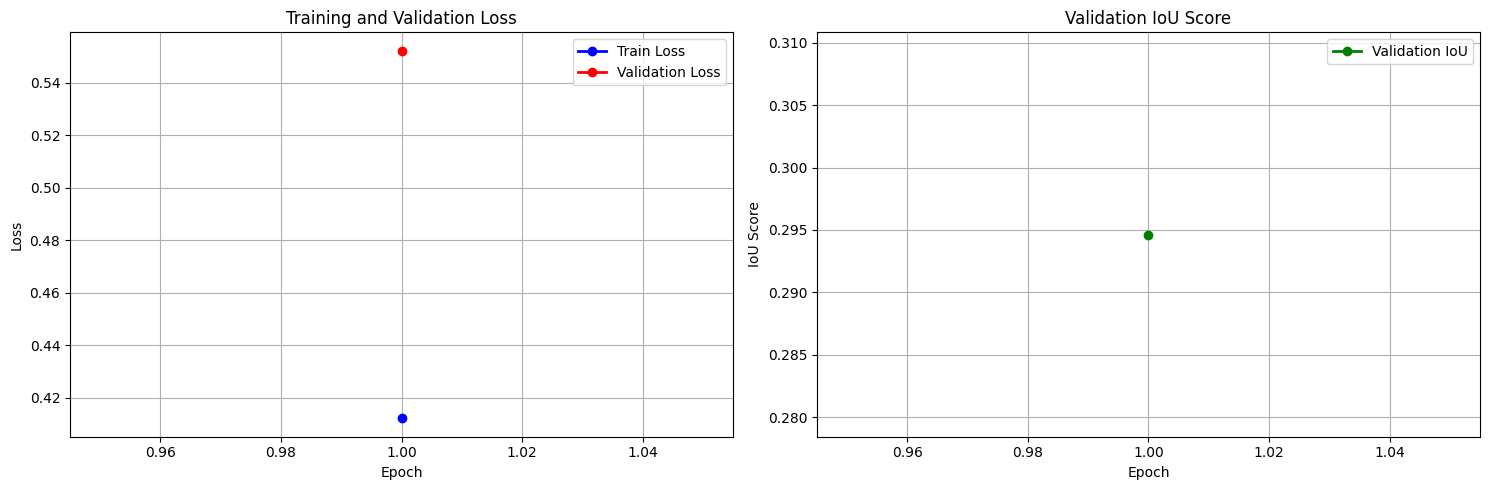

INFO:__main__:
Epoch 2/20
INFO:__main__:Batch 0/754, Loss: 0.2785
INFO:__main__:Batch 10/754, Loss: 0.3384
INFO:__main__:Batch 20/754, Loss: 0.2355
INFO:__main__:Batch 30/754, Loss: 0.1688
INFO:__main__:Batch 40/754, Loss: 0.3015
INFO:__main__:Batch 50/754, Loss: 0.3036
INFO:__main__:Batch 60/754, Loss: 0.2170
INFO:__main__:Batch 70/754, Loss: 0.1962
INFO:__main__:Batch 80/754, Loss: 0.3100
INFO:__main__:Batch 90/754, Loss: 0.2398
INFO:__main__:Batch 100/754, Loss: 0.1784
INFO:__main__:Batch 110/754, Loss: 0.3639
INFO:__main__:Batch 120/754, Loss: 0.2701
INFO:__main__:Batch 130/754, Loss: 0.2461
INFO:__main__:Batch 140/754, Loss: 0.2675
INFO:__main__:Batch 150/754, Loss: 0.2337
INFO:__main__:Batch 160/754, Loss: 0.2331
INFO:__main__:Batch 170/754, Loss: 0.2452
INFO:__main__:Batch 180/754, Loss: 0.3357
INFO:__main__:Batch 190/754, Loss: 0.1850
INFO:__main__:Batch 200/754, Loss: 0.3077
INFO:__main__:Batch 210/754, Loss: 0.1996
INFO:__main__:Batch 220/754, Loss: 0.1900
INFO:__main__:Batch

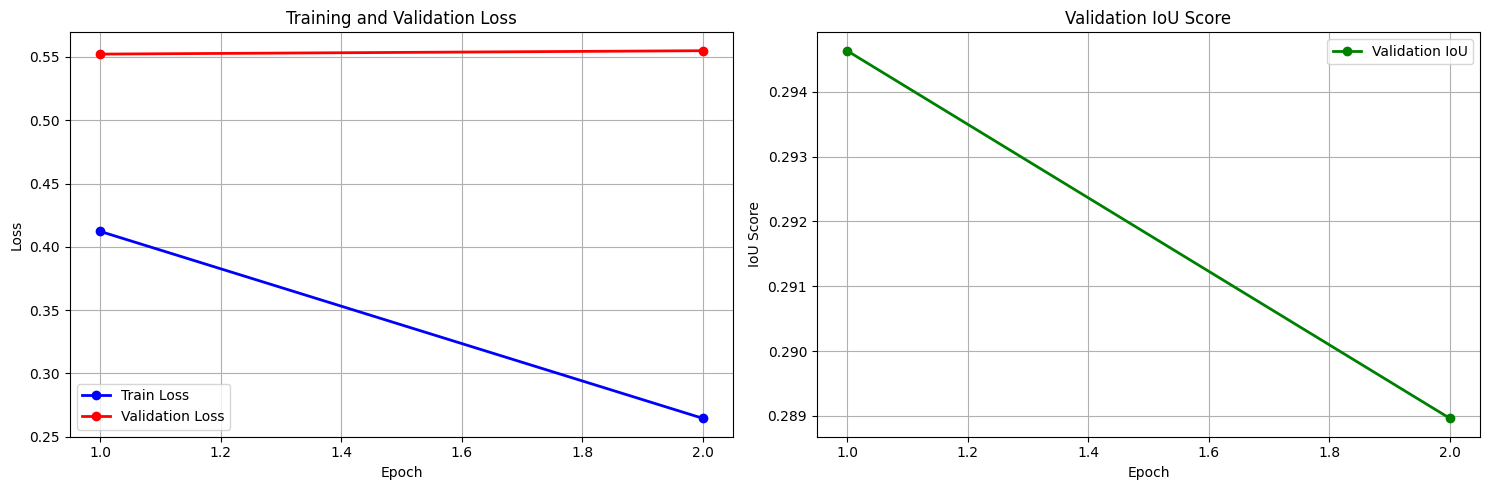

INFO:__main__:
Epoch 3/20
INFO:__main__:Batch 0/754, Loss: 0.1521
INFO:__main__:Batch 10/754, Loss: 0.2659
INFO:__main__:Batch 20/754, Loss: 0.1839
INFO:__main__:Batch 30/754, Loss: 0.1904
INFO:__main__:Batch 40/754, Loss: 0.1923
INFO:__main__:Batch 50/754, Loss: 0.2440
INFO:__main__:Batch 60/754, Loss: 0.2824
INFO:__main__:Batch 70/754, Loss: 0.1261
INFO:__main__:Batch 80/754, Loss: 0.1818
INFO:__main__:Batch 90/754, Loss: 0.2443
INFO:__main__:Batch 100/754, Loss: 0.3283
INFO:__main__:Batch 110/754, Loss: 0.1810
INFO:__main__:Batch 120/754, Loss: 0.2515
INFO:__main__:Batch 130/754, Loss: 0.2171
INFO:__main__:Batch 140/754, Loss: 0.2681
INFO:__main__:Batch 150/754, Loss: 0.3074
INFO:__main__:Batch 160/754, Loss: 0.2284
INFO:__main__:Batch 170/754, Loss: 0.2793
INFO:__main__:Batch 180/754, Loss: 0.1882
INFO:__main__:Batch 190/754, Loss: 0.1484
INFO:__main__:Batch 200/754, Loss: 0.2331
INFO:__main__:Batch 210/754, Loss: 0.1896
INFO:__main__:Batch 220/754, Loss: 0.2218
INFO:__main__:Batch

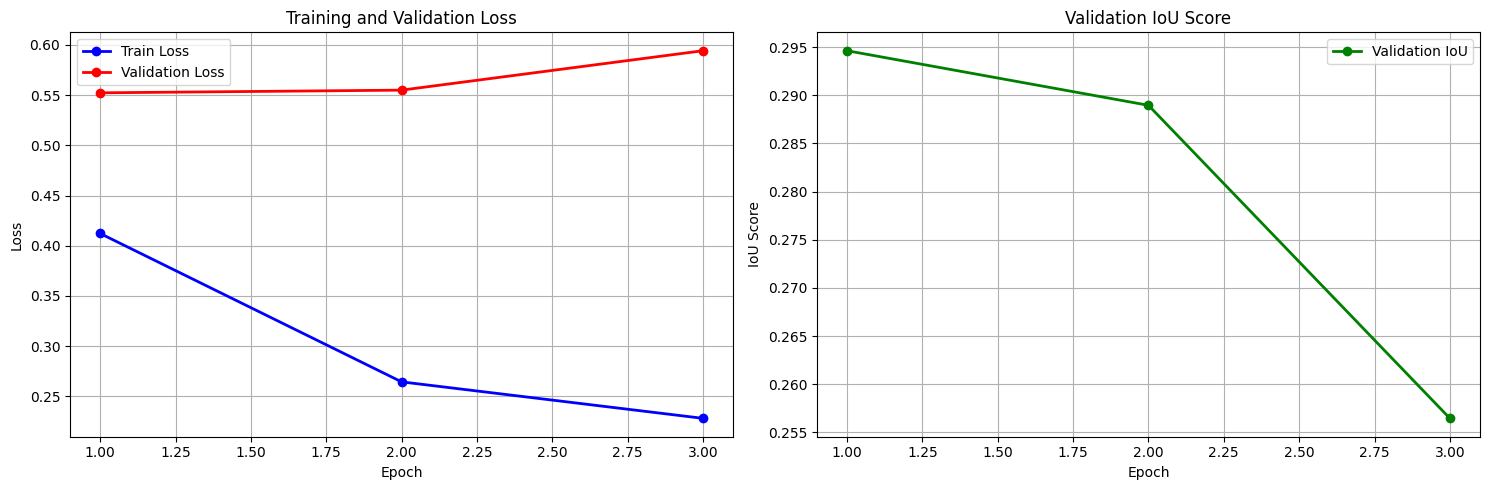

INFO:__main__:
Epoch 4/20
INFO:__main__:Batch 0/754, Loss: 0.0902
INFO:__main__:Batch 10/754, Loss: 0.2120
INFO:__main__:Batch 20/754, Loss: 0.1251
INFO:__main__:Batch 30/754, Loss: 0.3766
INFO:__main__:Batch 40/754, Loss: 0.1919
INFO:__main__:Batch 50/754, Loss: 0.1686
INFO:__main__:Batch 60/754, Loss: 0.1413
INFO:__main__:Batch 70/754, Loss: 0.2788
INFO:__main__:Batch 80/754, Loss: 0.1792
INFO:__main__:Batch 90/754, Loss: 0.2083
INFO:__main__:Batch 100/754, Loss: 0.1263
INFO:__main__:Batch 110/754, Loss: 0.1646
INFO:__main__:Batch 120/754, Loss: 0.3410
INFO:__main__:Batch 130/754, Loss: 0.2161
INFO:__main__:Batch 140/754, Loss: 0.2530
INFO:__main__:Batch 150/754, Loss: 0.1301
INFO:__main__:Batch 160/754, Loss: 0.1086
INFO:__main__:Batch 170/754, Loss: 0.3846
INFO:__main__:Batch 180/754, Loss: 0.2277
INFO:__main__:Batch 190/754, Loss: 0.1999
INFO:__main__:Batch 200/754, Loss: 0.1843
INFO:__main__:Batch 210/754, Loss: 0.1266
INFO:__main__:Batch 220/754, Loss: 0.1761
INFO:__main__:Batch

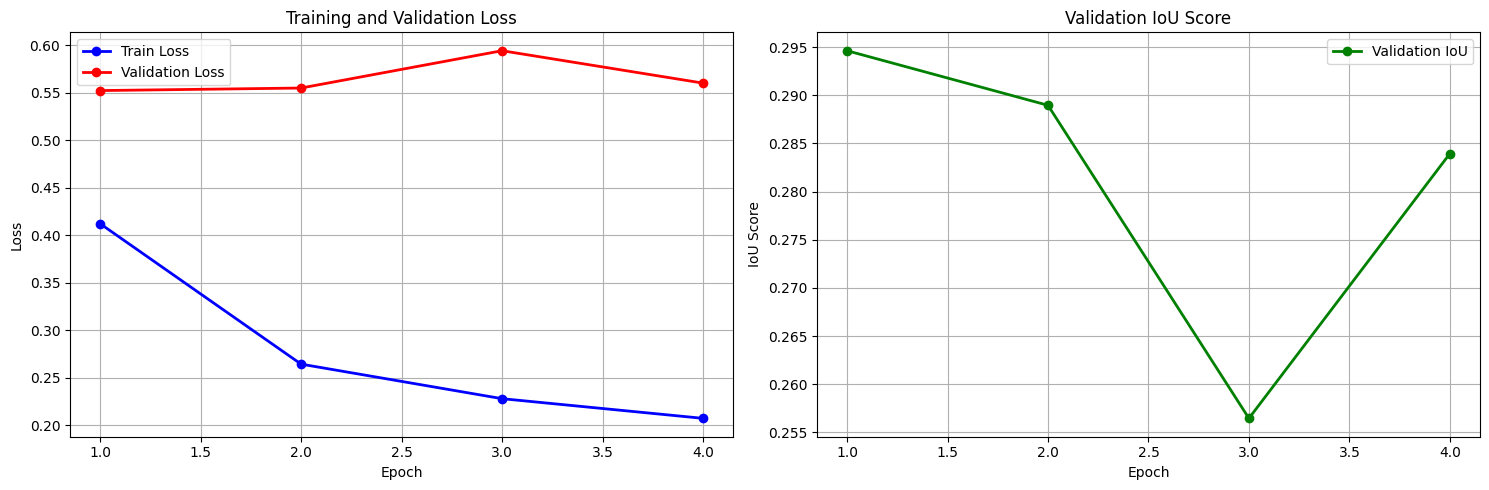

INFO:__main__:
Epoch 5/20
INFO:__main__:Batch 0/754, Loss: 0.1304
INFO:__main__:Batch 10/754, Loss: 0.1466
INFO:__main__:Batch 20/754, Loss: 0.1895
INFO:__main__:Batch 30/754, Loss: 0.2156
INFO:__main__:Batch 40/754, Loss: 0.1261
INFO:__main__:Batch 50/754, Loss: 0.2215
INFO:__main__:Batch 60/754, Loss: 0.1718
INFO:__main__:Batch 70/754, Loss: 0.2079
INFO:__main__:Batch 80/754, Loss: 0.1409
INFO:__main__:Batch 90/754, Loss: 0.1038
INFO:__main__:Batch 100/754, Loss: 0.1862
INFO:__main__:Batch 110/754, Loss: 0.2049
INFO:__main__:Batch 120/754, Loss: 0.1825
INFO:__main__:Batch 130/754, Loss: 0.3449
INFO:__main__:Batch 140/754, Loss: 0.1585
INFO:__main__:Batch 150/754, Loss: 0.1908
INFO:__main__:Batch 160/754, Loss: 0.2781
INFO:__main__:Batch 170/754, Loss: 0.1762
INFO:__main__:Batch 180/754, Loss: 0.1366
INFO:__main__:Batch 190/754, Loss: 0.2675
INFO:__main__:Batch 200/754, Loss: 0.1977
INFO:__main__:Batch 210/754, Loss: 0.2017
INFO:__main__:Batch 220/754, Loss: 0.2585
INFO:__main__:Batch

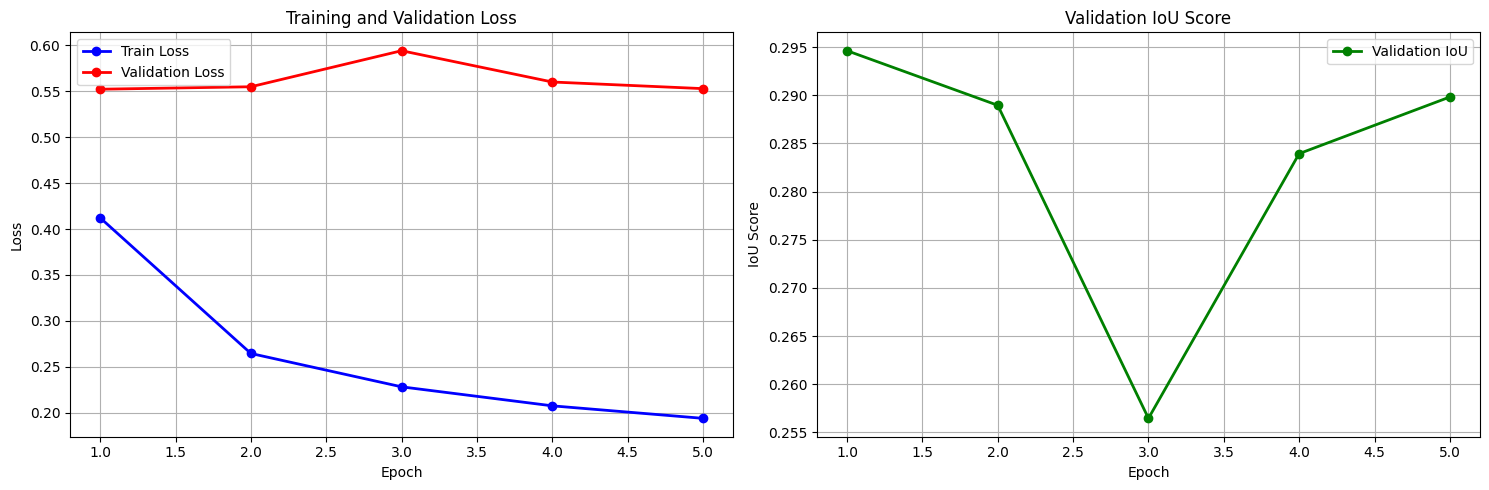

INFO:__main__:
Epoch 6/20
INFO:__main__:Batch 0/754, Loss: 0.1302
INFO:__main__:Batch 10/754, Loss: 0.1021
INFO:__main__:Batch 20/754, Loss: 0.2710
INFO:__main__:Batch 30/754, Loss: 0.1938
INFO:__main__:Batch 40/754, Loss: 0.0943
INFO:__main__:Batch 50/754, Loss: 0.0874
INFO:__main__:Batch 60/754, Loss: 0.2491
INFO:__main__:Batch 70/754, Loss: 0.3239
INFO:__main__:Batch 80/754, Loss: 0.1109
INFO:__main__:Batch 90/754, Loss: 0.1612
INFO:__main__:Batch 100/754, Loss: 0.2007
INFO:__main__:Batch 110/754, Loss: 0.2553
INFO:__main__:Batch 120/754, Loss: 0.1303
INFO:__main__:Batch 130/754, Loss: 0.1282
INFO:__main__:Batch 140/754, Loss: 0.1885
INFO:__main__:Batch 150/754, Loss: 0.0955
INFO:__main__:Batch 160/754, Loss: 0.0675
INFO:__main__:Batch 170/754, Loss: 0.4583
INFO:__main__:Batch 180/754, Loss: 0.0987
INFO:__main__:Batch 190/754, Loss: 0.3480
INFO:__main__:Batch 200/754, Loss: 0.1179
INFO:__main__:Batch 210/754, Loss: 0.1064
INFO:__main__:Batch 220/754, Loss: 0.1507
INFO:__main__:Batch

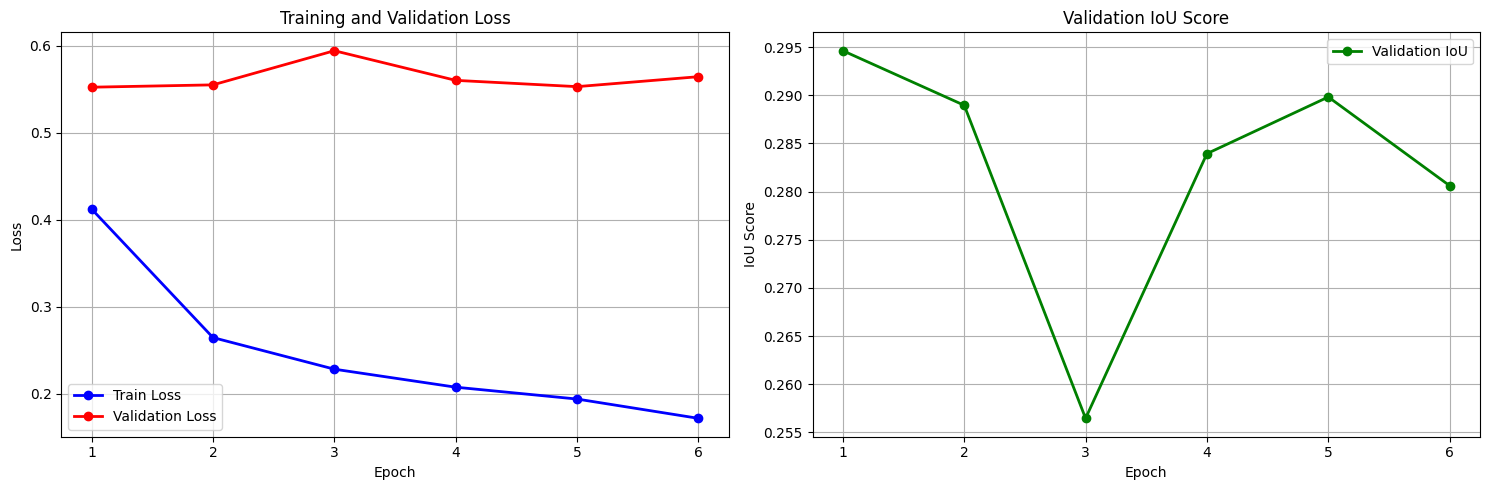

INFO:__main__:
Epoch 7/20
INFO:__main__:Batch 0/754, Loss: 0.1985
INFO:__main__:Batch 10/754, Loss: 0.1724
INFO:__main__:Batch 20/754, Loss: 0.2543
INFO:__main__:Batch 30/754, Loss: 0.1058
INFO:__main__:Batch 40/754, Loss: 0.1486
INFO:__main__:Batch 50/754, Loss: 0.1165
INFO:__main__:Batch 60/754, Loss: 0.0928
INFO:__main__:Batch 70/754, Loss: 0.2154
INFO:__main__:Batch 80/754, Loss: 0.1007
INFO:__main__:Batch 90/754, Loss: 0.1021
INFO:__main__:Batch 100/754, Loss: 0.2155
INFO:__main__:Batch 110/754, Loss: 0.1411
INFO:__main__:Batch 120/754, Loss: 0.0601
INFO:__main__:Batch 130/754, Loss: 0.1524
INFO:__main__:Batch 140/754, Loss: 0.1540
INFO:__main__:Batch 150/754, Loss: 0.1565
INFO:__main__:Batch 160/754, Loss: 0.0878
INFO:__main__:Batch 170/754, Loss: 0.1113
INFO:__main__:Batch 180/754, Loss: 0.1864
INFO:__main__:Batch 190/754, Loss: 0.0802
INFO:__main__:Batch 200/754, Loss: 0.1589
INFO:__main__:Batch 210/754, Loss: 0.1891
INFO:__main__:Batch 220/754, Loss: 0.1877
INFO:__main__:Batch

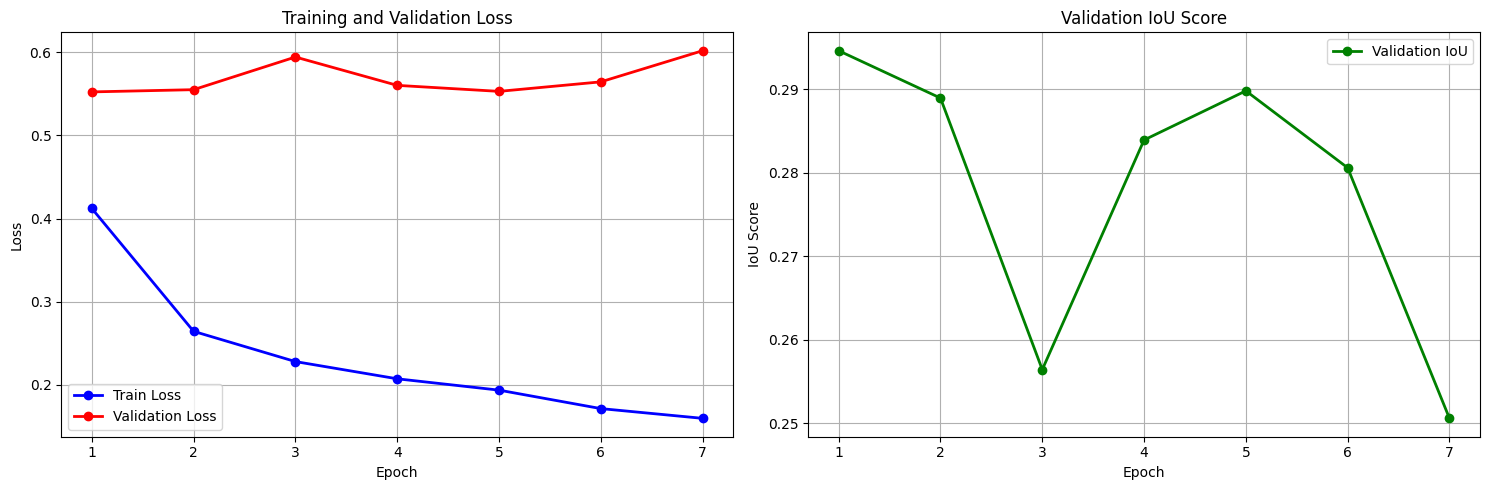

INFO:__main__:
Epoch 8/20
INFO:__main__:Batch 0/754, Loss: 0.2196
INFO:__main__:Batch 10/754, Loss: 0.1277
INFO:__main__:Batch 20/754, Loss: 0.1602
INFO:__main__:Batch 30/754, Loss: 0.1792
INFO:__main__:Batch 40/754, Loss: 0.2618
INFO:__main__:Batch 50/754, Loss: 0.1189
INFO:__main__:Batch 60/754, Loss: 0.1031
INFO:__main__:Batch 70/754, Loss: 0.1443
INFO:__main__:Batch 80/754, Loss: 0.0904
INFO:__main__:Batch 90/754, Loss: 0.1601
INFO:__main__:Batch 100/754, Loss: 0.2453
INFO:__main__:Batch 110/754, Loss: 0.1339
INFO:__main__:Batch 120/754, Loss: 0.1269
INFO:__main__:Batch 130/754, Loss: 0.1438
INFO:__main__:Batch 140/754, Loss: 0.1120
INFO:__main__:Batch 150/754, Loss: 0.1131
INFO:__main__:Batch 160/754, Loss: 0.2170
INFO:__main__:Batch 170/754, Loss: 0.2268
INFO:__main__:Batch 180/754, Loss: 0.1330
INFO:__main__:Batch 190/754, Loss: 0.1907
INFO:__main__:Batch 200/754, Loss: 0.0710
INFO:__main__:Batch 210/754, Loss: 0.1434
INFO:__main__:Batch 220/754, Loss: 0.1006
INFO:__main__:Batch

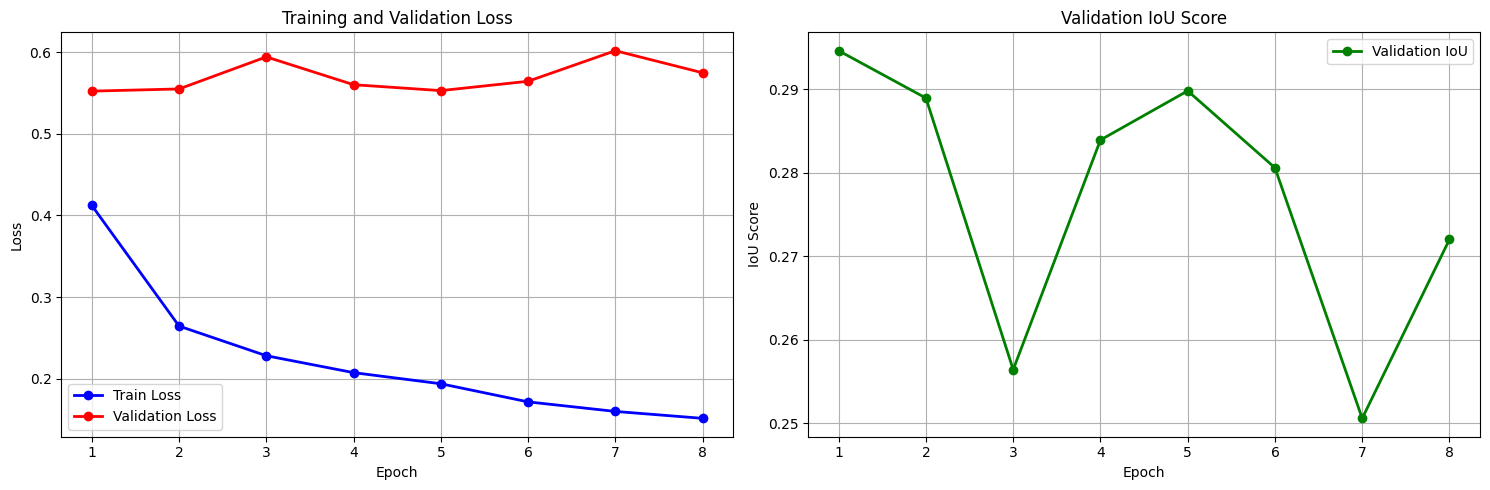

INFO:__main__:
Epoch 9/20
INFO:__main__:Batch 0/754, Loss: 0.1851
INFO:__main__:Batch 10/754, Loss: 0.1181
INFO:__main__:Batch 20/754, Loss: 0.1691
INFO:__main__:Batch 30/754, Loss: 0.1754
INFO:__main__:Batch 40/754, Loss: 0.1286
INFO:__main__:Batch 50/754, Loss: 0.1768
INFO:__main__:Batch 60/754, Loss: 0.1448
INFO:__main__:Batch 70/754, Loss: 0.1259
INFO:__main__:Batch 80/754, Loss: 0.1699
INFO:__main__:Batch 90/754, Loss: 0.1328
INFO:__main__:Batch 100/754, Loss: 0.1287
INFO:__main__:Batch 110/754, Loss: 0.1015
INFO:__main__:Batch 120/754, Loss: 0.1548
INFO:__main__:Batch 130/754, Loss: 0.0867
INFO:__main__:Batch 140/754, Loss: 0.0542
INFO:__main__:Batch 150/754, Loss: 0.1352
INFO:__main__:Batch 160/754, Loss: 0.1169
INFO:__main__:Batch 170/754, Loss: 0.1820
INFO:__main__:Batch 180/754, Loss: 0.1233
INFO:__main__:Batch 190/754, Loss: 0.1655
INFO:__main__:Batch 200/754, Loss: 0.1108
INFO:__main__:Batch 210/754, Loss: 0.1883
INFO:__main__:Batch 220/754, Loss: 0.0994
INFO:__main__:Batch

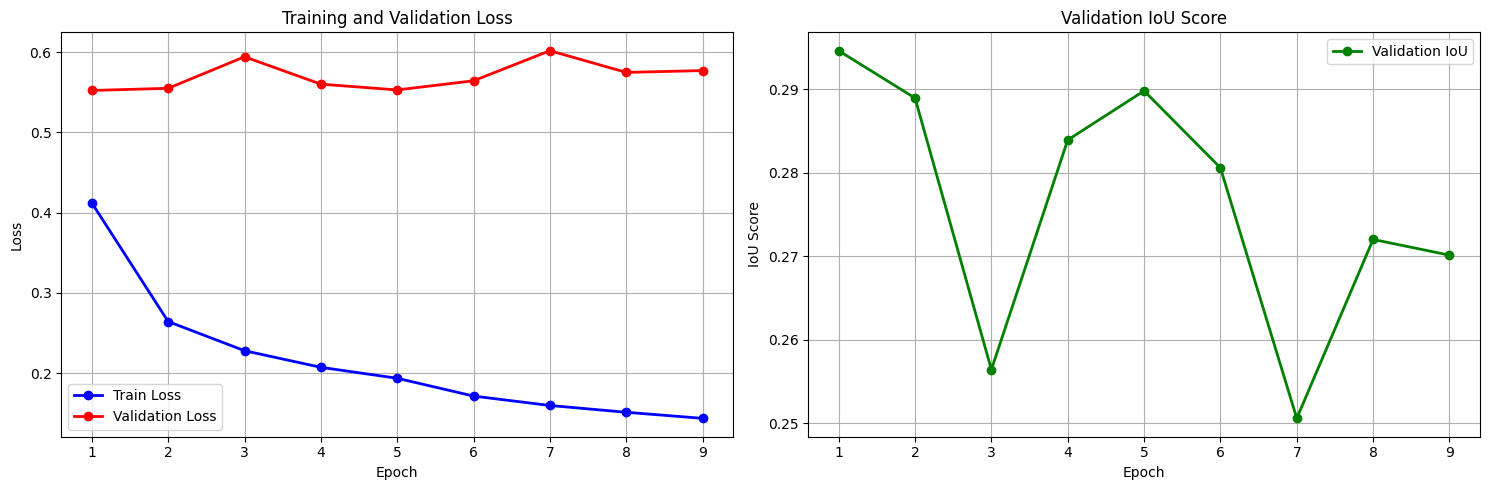

INFO:__main__:
Epoch 10/20
INFO:__main__:Batch 0/754, Loss: 0.3063
INFO:__main__:Batch 10/754, Loss: 0.1825
INFO:__main__:Batch 20/754, Loss: 0.0860
INFO:__main__:Batch 30/754, Loss: 0.0380
INFO:__main__:Batch 40/754, Loss: 0.0797
INFO:__main__:Batch 50/754, Loss: 0.1689
INFO:__main__:Batch 60/754, Loss: 0.1295
INFO:__main__:Batch 70/754, Loss: 0.1193
INFO:__main__:Batch 80/754, Loss: 0.1272
INFO:__main__:Batch 90/754, Loss: 0.0775
INFO:__main__:Batch 100/754, Loss: 0.0556
INFO:__main__:Batch 110/754, Loss: 0.1113
INFO:__main__:Batch 120/754, Loss: 0.1086
INFO:__main__:Batch 130/754, Loss: 0.1292
INFO:__main__:Batch 140/754, Loss: 0.1010
INFO:__main__:Batch 150/754, Loss: 0.2425
INFO:__main__:Batch 160/754, Loss: 0.0829
INFO:__main__:Batch 170/754, Loss: 0.1283
INFO:__main__:Batch 180/754, Loss: 0.1068
INFO:__main__:Batch 190/754, Loss: 0.1106
INFO:__main__:Batch 200/754, Loss: 0.0758
INFO:__main__:Batch 210/754, Loss: 0.1170
INFO:__main__:Batch 220/754, Loss: 0.0752
INFO:__main__:Batc

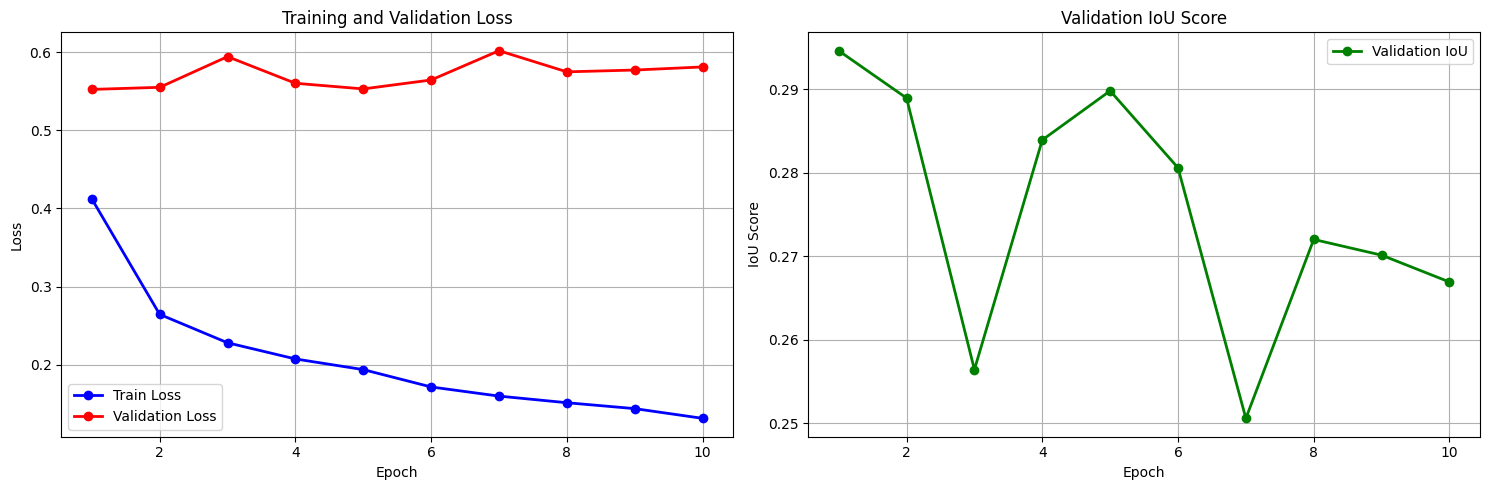

INFO:__main__:
Epoch 11/20
INFO:__main__:Batch 0/754, Loss: 0.0921
INFO:__main__:Batch 10/754, Loss: 0.1155
INFO:__main__:Batch 20/754, Loss: 0.1178
INFO:__main__:Batch 30/754, Loss: 0.0955
INFO:__main__:Batch 40/754, Loss: 0.0544
INFO:__main__:Batch 50/754, Loss: 0.1749
INFO:__main__:Batch 60/754, Loss: 0.1031
INFO:__main__:Batch 70/754, Loss: 0.0714
INFO:__main__:Batch 80/754, Loss: 0.0955
INFO:__main__:Batch 90/754, Loss: 0.1458
INFO:__main__:Batch 100/754, Loss: 0.0849
INFO:__main__:Batch 110/754, Loss: 0.1525
INFO:__main__:Batch 120/754, Loss: 0.1288
INFO:__main__:Batch 130/754, Loss: 0.1087
INFO:__main__:Batch 140/754, Loss: 0.0897
INFO:__main__:Batch 150/754, Loss: 0.0668
INFO:__main__:Batch 160/754, Loss: 0.1179
INFO:__main__:Batch 170/754, Loss: 0.1244
INFO:__main__:Batch 180/754, Loss: 0.0512
INFO:__main__:Batch 190/754, Loss: 0.1573
INFO:__main__:Batch 200/754, Loss: 0.1100
INFO:__main__:Batch 210/754, Loss: 0.1838
INFO:__main__:Batch 220/754, Loss: 0.1198
INFO:__main__:Batc

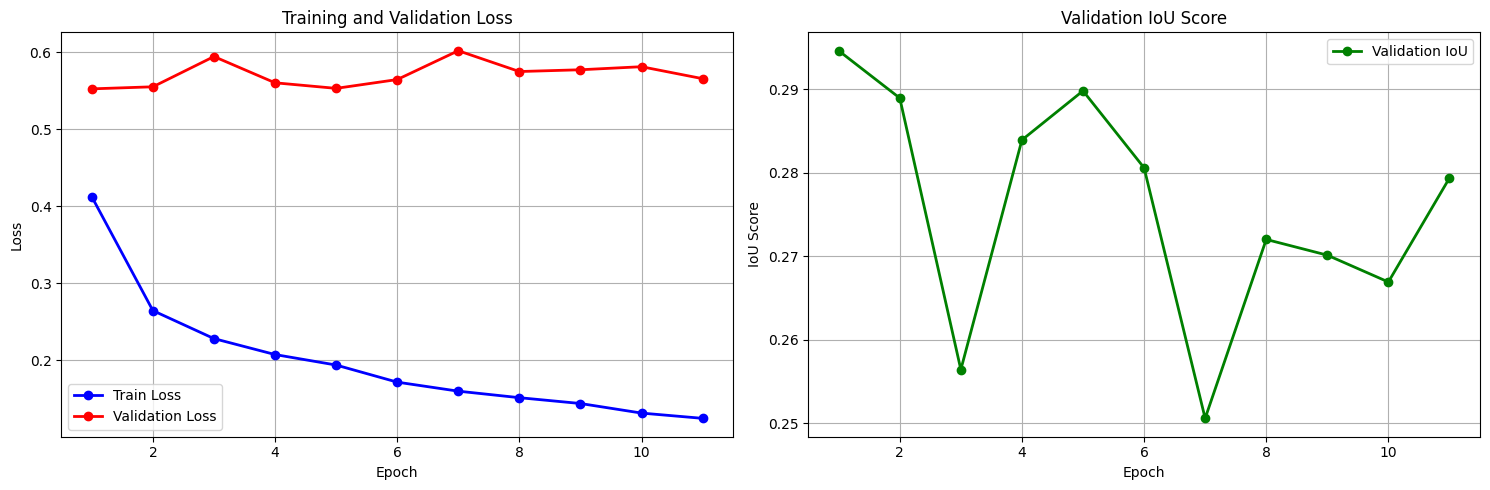

INFO:__main__:
Epoch 12/20
INFO:__main__:Batch 0/754, Loss: 0.0657
INFO:__main__:Batch 10/754, Loss: 0.0793
INFO:__main__:Batch 20/754, Loss: 0.0972
INFO:__main__:Batch 30/754, Loss: 0.1425
INFO:__main__:Batch 40/754, Loss: 0.0859
INFO:__main__:Batch 50/754, Loss: 0.1096
INFO:__main__:Batch 60/754, Loss: 0.0781
INFO:__main__:Batch 70/754, Loss: 0.1389
INFO:__main__:Batch 80/754, Loss: 0.0758
INFO:__main__:Batch 90/754, Loss: 0.0748
INFO:__main__:Batch 100/754, Loss: 0.1000
INFO:__main__:Batch 110/754, Loss: 0.0658
INFO:__main__:Batch 120/754, Loss: 0.0837
INFO:__main__:Batch 130/754, Loss: 0.0960
INFO:__main__:Batch 140/754, Loss: 0.1911
INFO:__main__:Batch 150/754, Loss: 0.1097
INFO:__main__:Batch 160/754, Loss: 0.0831
INFO:__main__:Batch 170/754, Loss: 0.0470
INFO:__main__:Batch 180/754, Loss: 0.1318
INFO:__main__:Batch 190/754, Loss: 0.1245
INFO:__main__:Batch 200/754, Loss: 0.1395
INFO:__main__:Batch 210/754, Loss: 0.0920
INFO:__main__:Batch 220/754, Loss: 0.1115
INFO:__main__:Batc

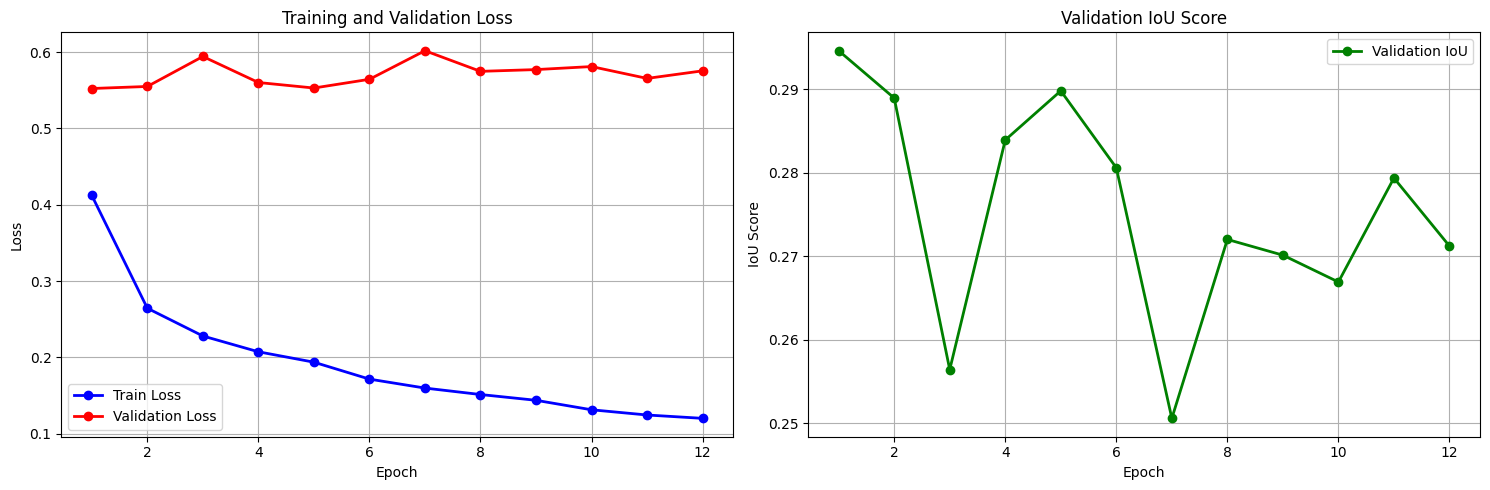

INFO:__main__:
Epoch 13/20
INFO:__main__:Batch 0/754, Loss: 0.1915
INFO:__main__:Batch 10/754, Loss: 0.1795
INFO:__main__:Batch 20/754, Loss: 0.1178
INFO:__main__:Batch 30/754, Loss: 0.1052
INFO:__main__:Batch 40/754, Loss: 0.1009
INFO:__main__:Batch 50/754, Loss: 0.1296
INFO:__main__:Batch 60/754, Loss: 0.0696
INFO:__main__:Batch 70/754, Loss: 0.1694
INFO:__main__:Batch 80/754, Loss: 0.1083
INFO:__main__:Batch 90/754, Loss: 0.1647
INFO:__main__:Batch 100/754, Loss: 0.1578
INFO:__main__:Batch 110/754, Loss: 0.1222
INFO:__main__:Batch 120/754, Loss: 0.1340
INFO:__main__:Batch 130/754, Loss: 0.0752
INFO:__main__:Batch 140/754, Loss: 0.1535
INFO:__main__:Batch 150/754, Loss: 0.0918
INFO:__main__:Batch 160/754, Loss: 0.1426
INFO:__main__:Batch 170/754, Loss: 0.0817
INFO:__main__:Batch 180/754, Loss: 0.0973
INFO:__main__:Batch 190/754, Loss: 0.1298
INFO:__main__:Batch 200/754, Loss: 0.1586
INFO:__main__:Batch 210/754, Loss: 0.0418
INFO:__main__:Batch 220/754, Loss: 0.2305
INFO:__main__:Batc

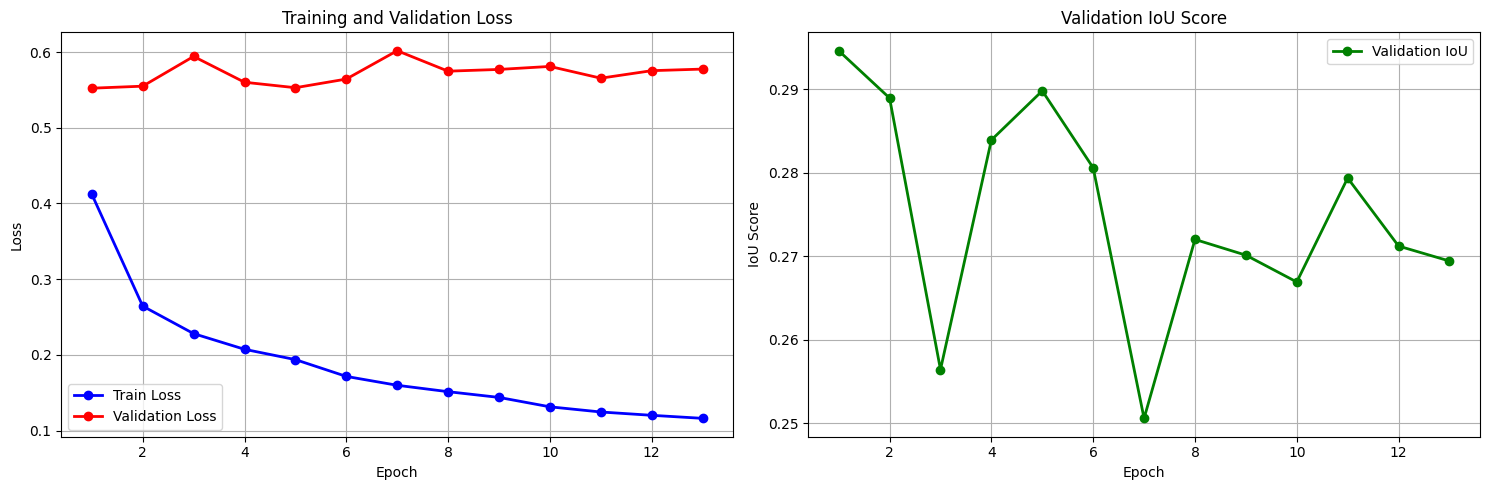

INFO:__main__:
Epoch 14/20
INFO:__main__:Batch 0/754, Loss: 0.2047
INFO:__main__:Batch 10/754, Loss: 0.0982
INFO:__main__:Batch 20/754, Loss: 0.0996
INFO:__main__:Batch 30/754, Loss: 0.1037
INFO:__main__:Batch 40/754, Loss: 0.1594
INFO:__main__:Batch 50/754, Loss: 0.0787
INFO:__main__:Batch 60/754, Loss: 0.1472
INFO:__main__:Batch 70/754, Loss: 0.1572
INFO:__main__:Batch 80/754, Loss: 0.0659
INFO:__main__:Batch 90/754, Loss: 0.0682
INFO:__main__:Batch 100/754, Loss: 0.0490
INFO:__main__:Batch 110/754, Loss: 0.1398
INFO:__main__:Batch 120/754, Loss: 0.1158
INFO:__main__:Batch 130/754, Loss: 0.0305
INFO:__main__:Batch 140/754, Loss: 0.1302
INFO:__main__:Batch 150/754, Loss: 0.0670
INFO:__main__:Batch 160/754, Loss: 0.1169
INFO:__main__:Batch 170/754, Loss: 0.1417
INFO:__main__:Batch 180/754, Loss: 0.1135
INFO:__main__:Batch 190/754, Loss: 0.1031
INFO:__main__:Batch 200/754, Loss: 0.0854
INFO:__main__:Batch 210/754, Loss: 0.1425
INFO:__main__:Batch 220/754, Loss: 0.0913
INFO:__main__:Batc

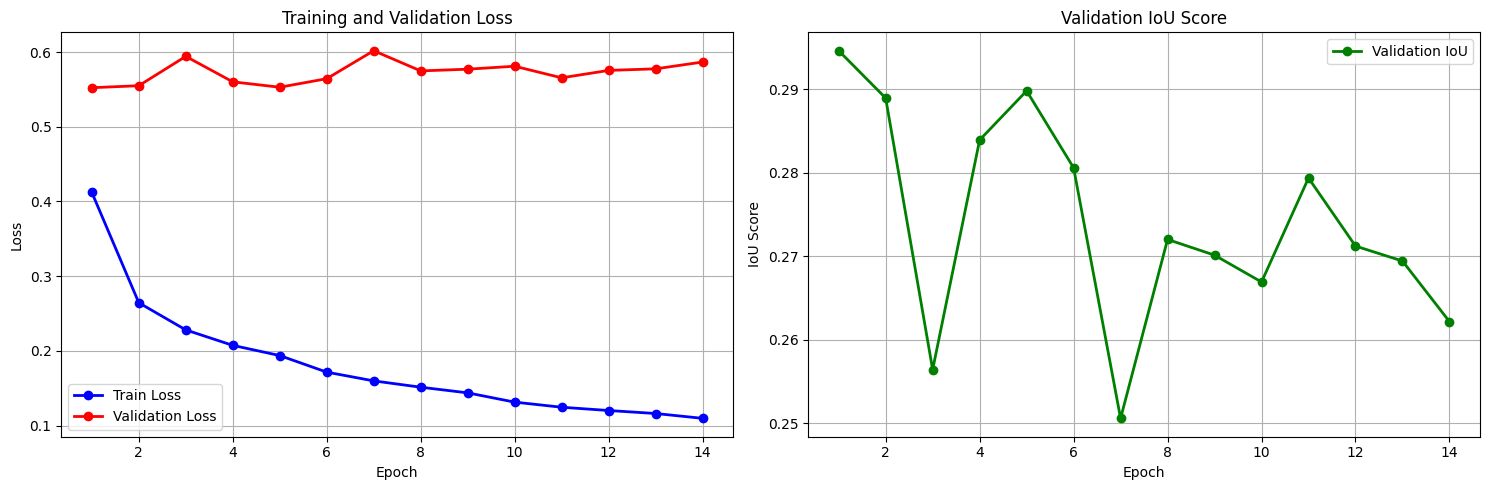

INFO:__main__:
Epoch 15/20
INFO:__main__:Batch 0/754, Loss: 0.1918
INFO:__main__:Batch 10/754, Loss: 0.1065
INFO:__main__:Batch 20/754, Loss: 0.0591
INFO:__main__:Batch 30/754, Loss: 0.1273
INFO:__main__:Batch 40/754, Loss: 0.1599
INFO:__main__:Batch 50/754, Loss: 0.0711
INFO:__main__:Batch 60/754, Loss: 0.1047
INFO:__main__:Batch 70/754, Loss: 0.0636
INFO:__main__:Batch 80/754, Loss: 0.0464
INFO:__main__:Batch 90/754, Loss: 0.0947
INFO:__main__:Batch 100/754, Loss: 0.1000
INFO:__main__:Batch 110/754, Loss: 0.1495
INFO:__main__:Batch 120/754, Loss: 0.0907
INFO:__main__:Batch 130/754, Loss: 0.0535
INFO:__main__:Batch 140/754, Loss: 0.1258
INFO:__main__:Batch 150/754, Loss: 0.0882
INFO:__main__:Batch 160/754, Loss: 0.1682
INFO:__main__:Batch 170/754, Loss: 0.1125
INFO:__main__:Batch 180/754, Loss: 0.1228
INFO:__main__:Batch 190/754, Loss: 0.1395
INFO:__main__:Batch 200/754, Loss: 0.1261
INFO:__main__:Batch 210/754, Loss: 0.0595
INFO:__main__:Batch 220/754, Loss: 0.1591
INFO:__main__:Batc

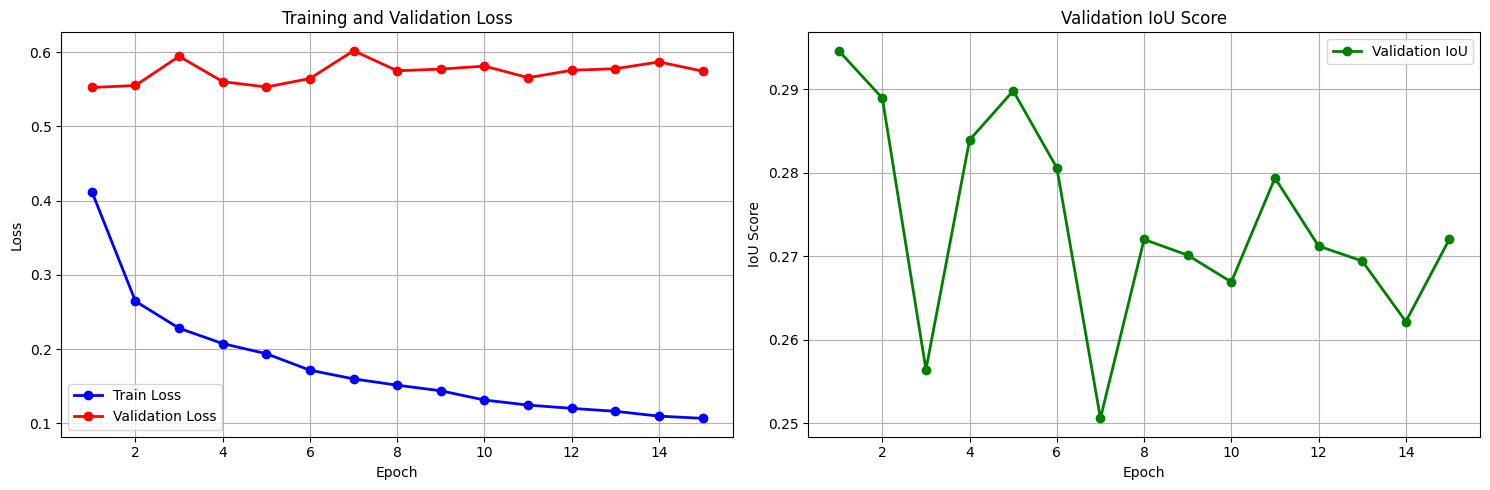

INFO:__main__:
Epoch 16/20
INFO:__main__:Batch 0/754, Loss: 0.1471
INFO:__main__:Batch 10/754, Loss: 0.0954
INFO:__main__:Batch 20/754, Loss: 0.1044
INFO:__main__:Batch 30/754, Loss: 0.1120
INFO:__main__:Batch 40/754, Loss: 0.2124
INFO:__main__:Batch 50/754, Loss: 0.0589
INFO:__main__:Batch 60/754, Loss: 0.1034
INFO:__main__:Batch 70/754, Loss: 0.0981
INFO:__main__:Batch 80/754, Loss: 0.0668
INFO:__main__:Batch 90/754, Loss: 0.1140
INFO:__main__:Batch 100/754, Loss: 0.1096
INFO:__main__:Batch 110/754, Loss: 0.0607
INFO:__main__:Batch 120/754, Loss: 0.0862
INFO:__main__:Batch 130/754, Loss: 0.1128
INFO:__main__:Batch 140/754, Loss: 0.1446
INFO:__main__:Batch 150/754, Loss: 0.0845
INFO:__main__:Batch 160/754, Loss: 0.0835
INFO:__main__:Batch 170/754, Loss: 0.1807
INFO:__main__:Batch 180/754, Loss: 0.0545
INFO:__main__:Batch 190/754, Loss: 0.1121
INFO:__main__:Batch 200/754, Loss: 0.0858
INFO:__main__:Batch 210/754, Loss: 0.0946
INFO:__main__:Batch 220/754, Loss: 0.0579
INFO:__main__:Batc

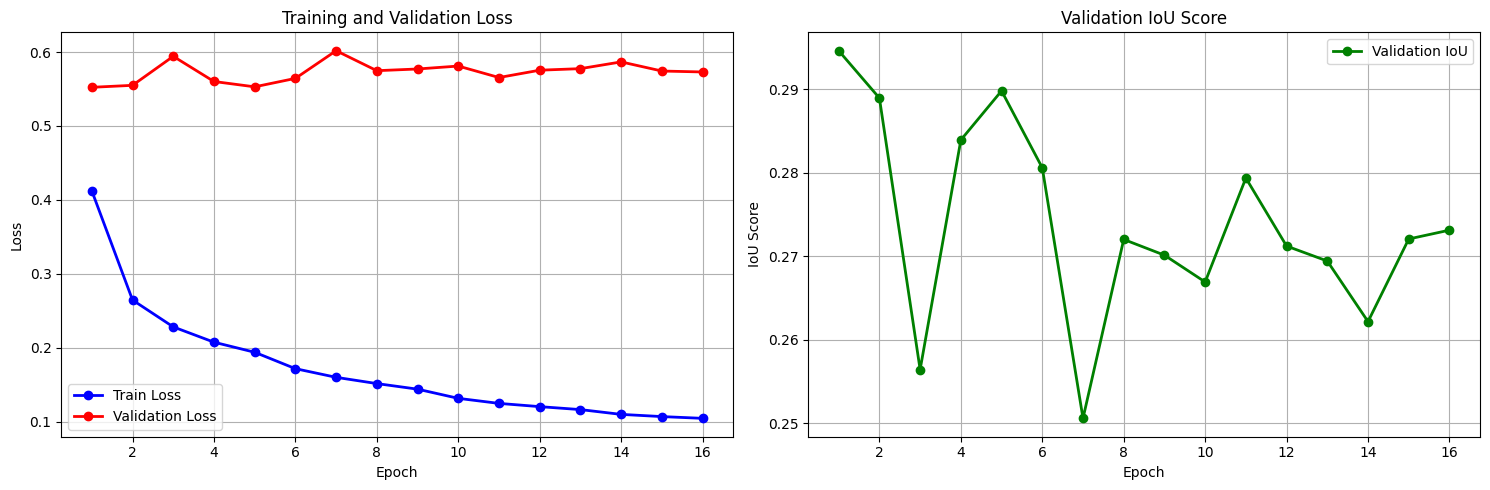

INFO:__main__:
Epoch 17/20
INFO:__main__:Batch 0/754, Loss: 0.0859
INFO:__main__:Batch 10/754, Loss: 0.0781
INFO:__main__:Batch 20/754, Loss: 0.0661
INFO:__main__:Batch 30/754, Loss: 0.1317
INFO:__main__:Batch 40/754, Loss: 0.1010
INFO:__main__:Batch 50/754, Loss: 0.1075
INFO:__main__:Batch 60/754, Loss: 0.1802
INFO:__main__:Batch 70/754, Loss: 0.0623
INFO:__main__:Batch 80/754, Loss: 0.0843
INFO:__main__:Batch 90/754, Loss: 0.0691
INFO:__main__:Batch 100/754, Loss: 0.1473
INFO:__main__:Batch 110/754, Loss: 0.0561
INFO:__main__:Batch 120/754, Loss: 0.2649
INFO:__main__:Batch 130/754, Loss: 0.0643
INFO:__main__:Batch 140/754, Loss: 0.0740
INFO:__main__:Batch 150/754, Loss: 0.1657
INFO:__main__:Batch 160/754, Loss: 0.1247
INFO:__main__:Batch 170/754, Loss: 0.1061
INFO:__main__:Batch 180/754, Loss: 0.0959
INFO:__main__:Batch 190/754, Loss: 0.1652
INFO:__main__:Batch 200/754, Loss: 0.0486
INFO:__main__:Batch 210/754, Loss: 0.1265
INFO:__main__:Batch 220/754, Loss: 0.0890
INFO:__main__:Batc

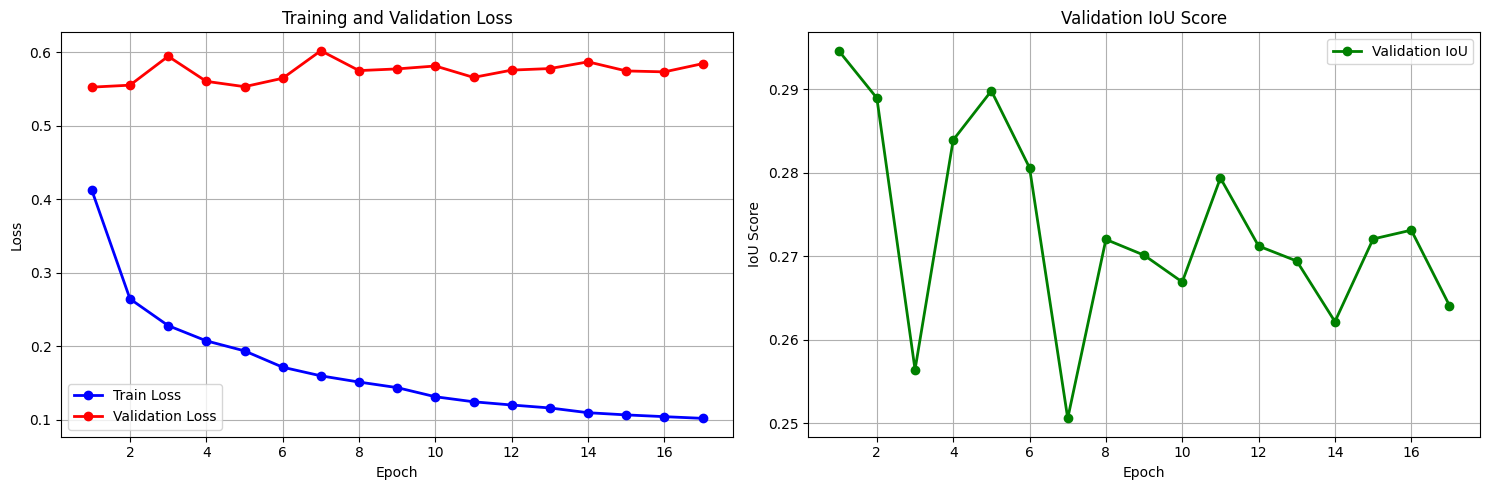

INFO:__main__:
Epoch 18/20
INFO:__main__:Batch 0/754, Loss: 0.1435
INFO:__main__:Batch 10/754, Loss: 0.0652
INFO:__main__:Batch 20/754, Loss: 0.0983
INFO:__main__:Batch 30/754, Loss: 0.0888
INFO:__main__:Batch 40/754, Loss: 0.0482
INFO:__main__:Batch 50/754, Loss: 0.1155
INFO:__main__:Batch 60/754, Loss: 0.1244
INFO:__main__:Batch 70/754, Loss: 0.0599
INFO:__main__:Batch 80/754, Loss: 0.0942
INFO:__main__:Batch 90/754, Loss: 0.0578
INFO:__main__:Batch 100/754, Loss: 0.0774
INFO:__main__:Batch 110/754, Loss: 0.0431
INFO:__main__:Batch 120/754, Loss: 0.0716
INFO:__main__:Batch 130/754, Loss: 0.0840
INFO:__main__:Batch 140/754, Loss: 0.0788
INFO:__main__:Batch 150/754, Loss: 0.1347
INFO:__main__:Batch 160/754, Loss: 0.1280
INFO:__main__:Batch 170/754, Loss: 0.0524
INFO:__main__:Batch 180/754, Loss: 0.0522
INFO:__main__:Batch 190/754, Loss: 0.1032
INFO:__main__:Batch 200/754, Loss: 0.0536
INFO:__main__:Batch 210/754, Loss: 0.1599
INFO:__main__:Batch 220/754, Loss: 0.1904
INFO:__main__:Batc

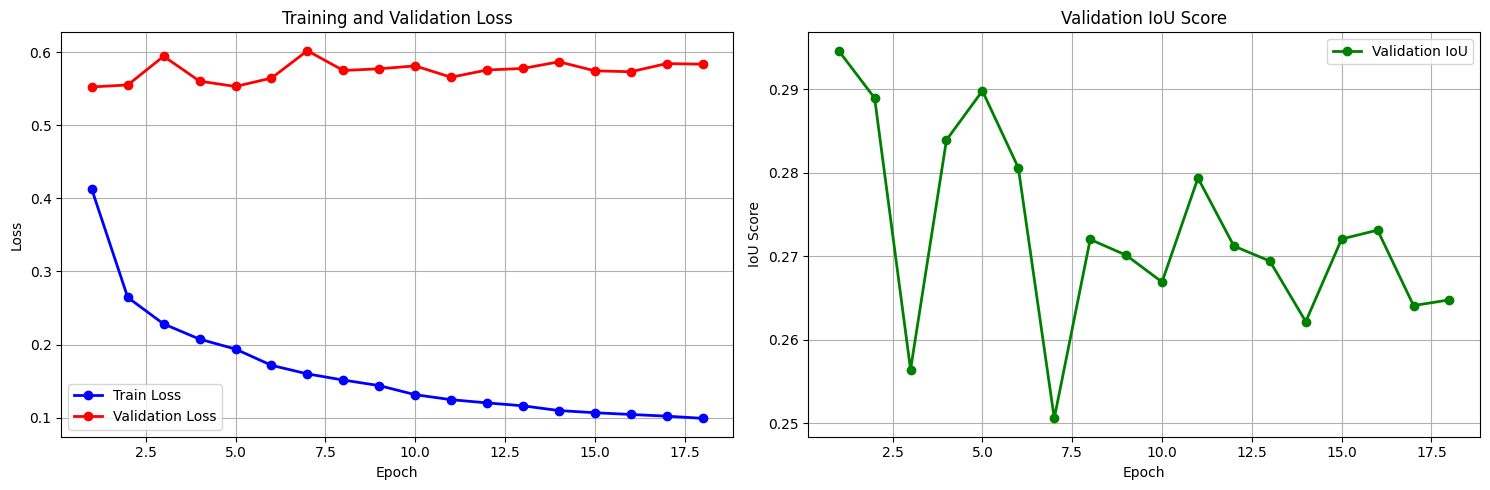

INFO:__main__:
Epoch 19/20
INFO:__main__:Batch 0/754, Loss: 0.1575
INFO:__main__:Batch 10/754, Loss: 0.0345
INFO:__main__:Batch 20/754, Loss: 0.1633
INFO:__main__:Batch 30/754, Loss: 0.1714
INFO:__main__:Batch 40/754, Loss: 0.0600
INFO:__main__:Batch 50/754, Loss: 0.0695
INFO:__main__:Batch 60/754, Loss: 0.1095
INFO:__main__:Batch 70/754, Loss: 0.0994
INFO:__main__:Batch 80/754, Loss: 0.0678
INFO:__main__:Batch 90/754, Loss: 0.0576
INFO:__main__:Batch 100/754, Loss: 0.0800
INFO:__main__:Batch 110/754, Loss: 0.1335
INFO:__main__:Batch 120/754, Loss: 0.0606
INFO:__main__:Batch 130/754, Loss: 0.0614
INFO:__main__:Batch 140/754, Loss: 0.1725
INFO:__main__:Batch 150/754, Loss: 0.0687
INFO:__main__:Batch 160/754, Loss: 0.0956
INFO:__main__:Batch 170/754, Loss: 0.0870
INFO:__main__:Batch 180/754, Loss: 0.0896
INFO:__main__:Batch 190/754, Loss: 0.1519
INFO:__main__:Batch 200/754, Loss: 0.1148
INFO:__main__:Batch 210/754, Loss: 0.1400
INFO:__main__:Batch 220/754, Loss: 0.0623
INFO:__main__:Batc

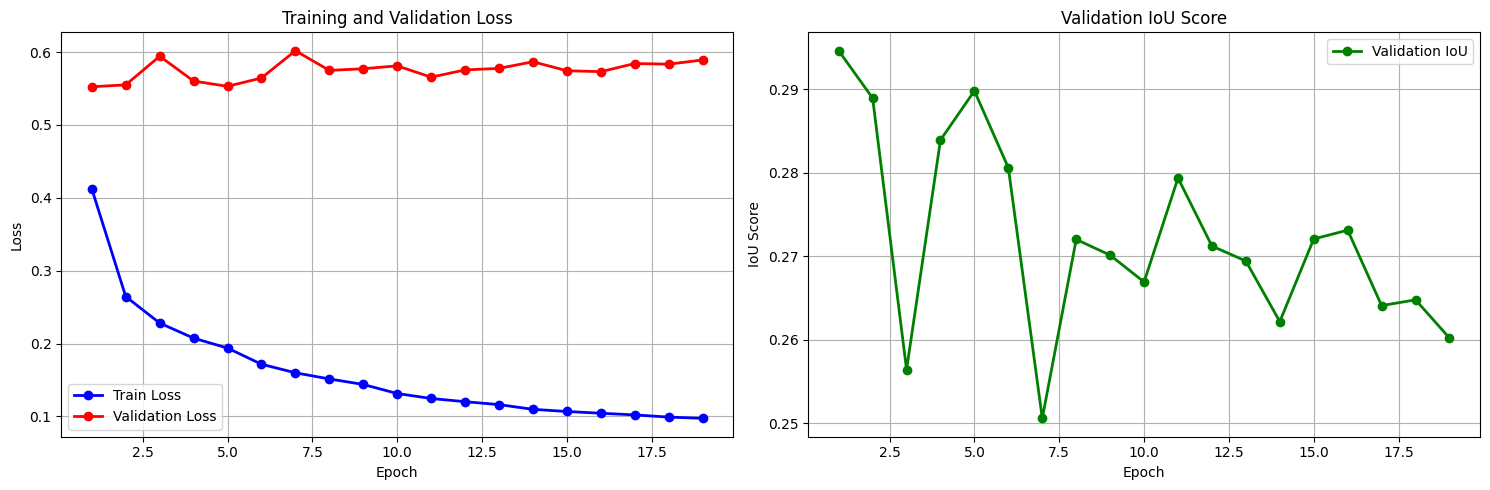

INFO:__main__:
Epoch 20/20
INFO:__main__:Batch 0/754, Loss: 0.1332
INFO:__main__:Batch 10/754, Loss: 0.0649
INFO:__main__:Batch 20/754, Loss: 0.0968
INFO:__main__:Batch 30/754, Loss: 0.1443
INFO:__main__:Batch 40/754, Loss: 0.0584
INFO:__main__:Batch 50/754, Loss: 0.1134
INFO:__main__:Batch 60/754, Loss: 0.0966
INFO:__main__:Batch 70/754, Loss: 0.0536
INFO:__main__:Batch 80/754, Loss: 0.0900
INFO:__main__:Batch 90/754, Loss: 0.0599
INFO:__main__:Batch 100/754, Loss: 0.0540
INFO:__main__:Batch 110/754, Loss: 0.1471
INFO:__main__:Batch 120/754, Loss: 0.0517
INFO:__main__:Batch 130/754, Loss: 0.1080
INFO:__main__:Batch 140/754, Loss: 0.0792
INFO:__main__:Batch 150/754, Loss: 0.0777
INFO:__main__:Batch 160/754, Loss: 0.1072
INFO:__main__:Batch 170/754, Loss: 0.0770
INFO:__main__:Batch 180/754, Loss: 0.0838
INFO:__main__:Batch 190/754, Loss: 0.1409
INFO:__main__:Batch 200/754, Loss: 0.0569
INFO:__main__:Batch 210/754, Loss: 0.1097
INFO:__main__:Batch 220/754, Loss: 0.1319
INFO:__main__:Batc

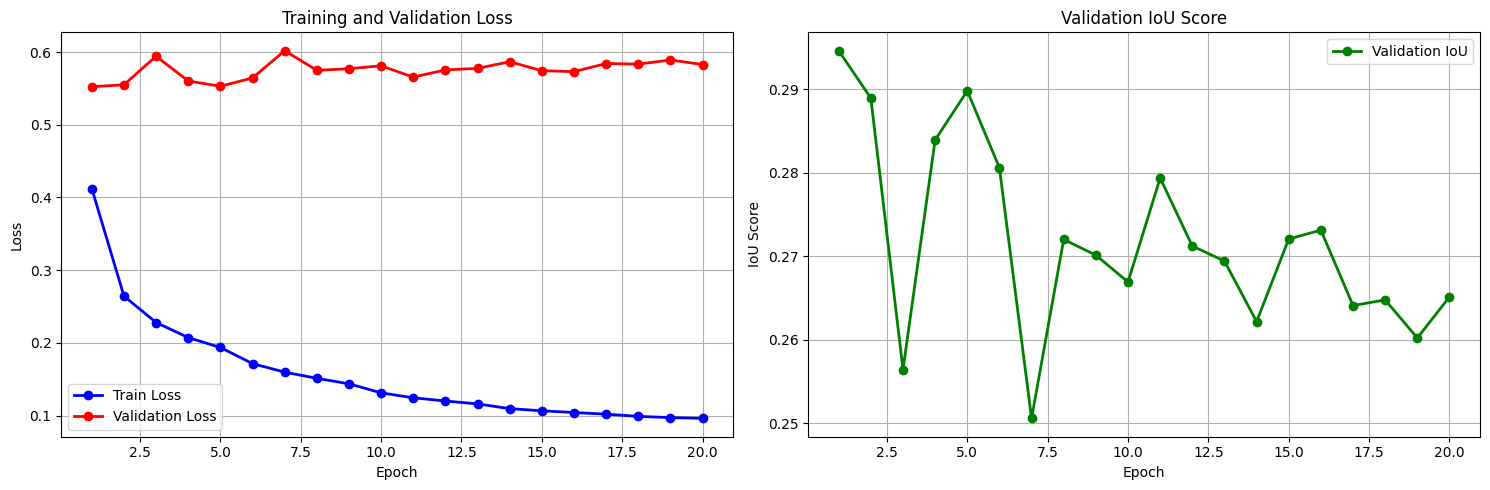

INFO:__main__:Using device for testing: cuda
/tmp/ipykernel_15474/3887567501.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_loc

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
if __name__ == '__main__':
     try:
         # Train the model (optional, comment out if you only want to test)
         model, history = main()

        #  # Example inference using test_segmentation_function
        #  test_image_path = "/home/sahil-duwal/Downloads/archive(1)/FF++Faces/test/fake/video_014_frame_0024.png"  # Update with your test image path
        #  mask = test_segmentation_function(test_image_path)

     except Exception as e:
         logger.error(f"Error in main execution: {str(e)}")
         raise

INFO:__main__:Using device for testing: cuda
/tmp/ipykernel_15474/3887567501.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_loc

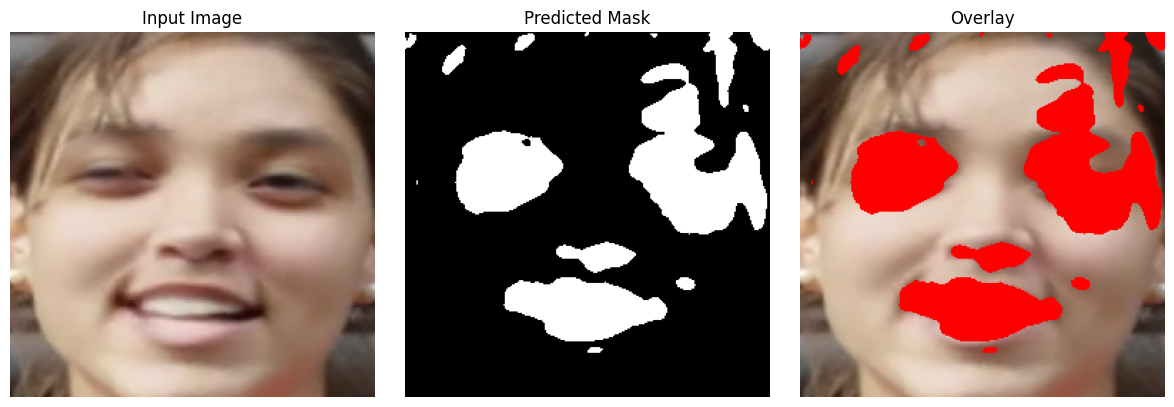

INFO:__main__:Segmentation complete. Check the displayed results.


In [19]:
if __name__ == '__main__':
     try:
        #  # Train the model (optional, comment out if you only want to test)
        #  model, history = main()

         # Example inference using test_segmentation_function
         test_image_path = "/home/sahil-duwal/Downloads/archive(1)/FF++Faces/test/fake/video_0144_frame_0003.png"  # Update with your test image path
         mask = test_segmentation_function(test_image_path)

     except Exception as e:
         logger.error(f"Error in main execution: {str(e)}")
         raise